<a href="https://colab.research.google.com/github/Szuyingpan/NLP-Project-RoBERTa/blob/main/NLP_Sentiment_Analysis_RoBERTa_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Natural Language Processing for Sentiment Analysis by using Amazon reviews dataset

This notebook is followed by another notebook named 'NLP_Sentiment Analysis_LSTM_Final.' The goal is to first apply an LSTM model and then Huggingface's RoBERTa transformers. We aim to compare the results using a corpus of data trained models. In doing so, the Transformer model not only accounts for individual words but also considers the context related to other words.

In [1]:
# Setup environment

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Library

In [3]:
import bz2
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm


In [4]:
# add this for pandas, to better look at the data
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

## 2. Import data

In [7]:
import pandas as pd

NUMBER_OF_LINES = 9000

data = {}

# Counter to keep track of the number of processed lines
i = 0

# Open the file and read line by line
with open('/content/drive/MyDrive/Colab Notebooks/train.ft.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Check if we have processed the desired number of lines
        if i == NUMBER_OF_LINES:
            break

        # Determine the label based on the line prefix
        label = 1 if line[:10] == "__label__1" else 2

        # Extract the text, removing the label part
        text = line[10:].strip() # Also strip to remove leading/trailing whitespaces

        # Store the processed line in the dictionary
        data[i] = {"label": label, "text": text}

        # Increment the counter
        i += 1

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data, orient='index')
df = df.reset_index().rename(columns={"index": "Id"})

# Display the first few rows of the DataFrame to verify
print(df.head())


   Id  label                                               text
0   0      2  Stuning even for the non-gamer: This sound tra...
1   1      2  The best soundtrack ever to anything.: I'm rea...
2   2      2  Amazing!: This soundtrack is my favorite music...
3   3      2  Excellent Soundtrack: I truly like this soundt...
4   4      2  Remember, Pull Your Jaw Off The Floor After He...


   Id  label                                               text
0   0      2  Stuning even for the non-gamer: This sound tra...
1   1      2  The best soundtrack ever to anything.: I'm rea...
2   2      2  Amazing!: This soundtrack is my favorite music...
3   3      2  Excellent Soundtrack: I truly like this soundt...
4   4      2  Remember, Pull Your Jaw Off The Floor After He...
5   5      2  an absolute masterpiece: I am quite sure any o...
6   6      1  Buyer beware: This is a self-published book, a...
7   7      2  Glorious story: I loved Whisper of the wicked ...
8   8      2  A FIVE STAR BOOK: I just finished reading Whis...
9   9      2  Whispers of the Wicked Saints: This was a easy...
the shape of the data (9000, 3)
unique labels [2 1]
1    4616
2    4384
Name: label, dtype: int64


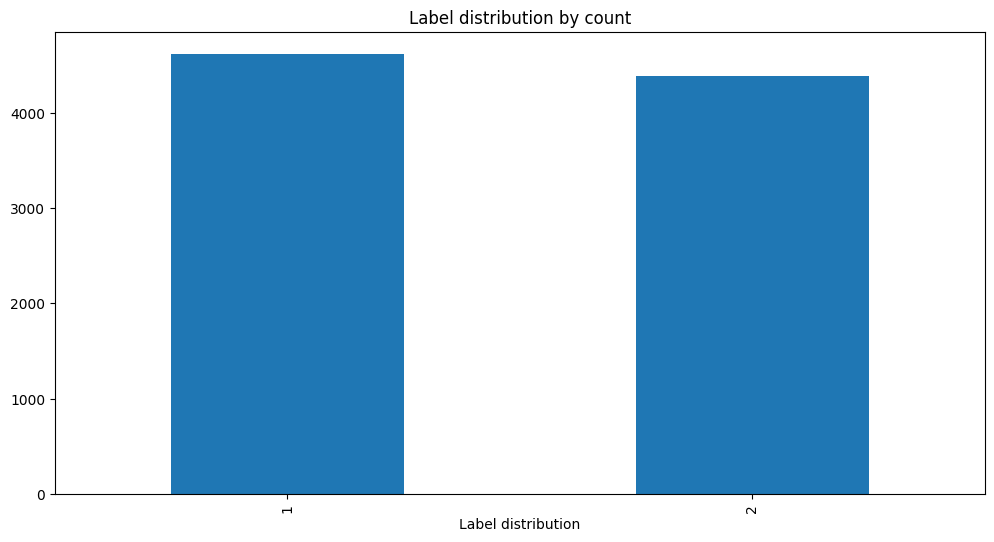

In [8]:
print(df.head(10))

print("the shape of the data", df.shape)

print("unique labels", df["label"].unique())

valueCounts = df["label"].value_counts().sort_index()
print(valueCounts)

ax = valueCounts.plot(kind="bar", title="Label distribution by count", figsize=(12, 6))
ax.set_xlabel("Label distribution")
plt.show()

In [9]:
import pandas as pd

NUMBER_OF_LINES = 1000

data = {}

# Counter to keep track of the number of processed lines
i = 0

# Open the file and read line by line
with open('/content/drive/MyDrive/Colab Notebooks/test.ft.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Check if we have processed the desired number of lines
        if i == NUMBER_OF_LINES:
            break

        # Determine the label based on the line prefix
        label = 1 if line[:10] == "__label__1" else 2

        # Extract the text, removing the label part
        text = line[10:].strip() # Also strip to remove leading/trailing whitespaces

        # Store the processed line in the dictionary
        data[i] = {"label": label, "text": text}

        # Increment the counter
        i += 1

# Convert the dictionary to a pandas DataFrame
test = pd.DataFrame.from_dict(data, orient='index')
test = test.reset_index().rename(columns={"index": "Id"})

# Display the first few rows of the DataFrame to verify
print(test.head())


   Id  label                                               text
0   0      2  Great CD: My lovely Pat has one of the GREAT v...
1   1      2  One of the best game music soundtracks - for a...
2   2      1  Batteries died within a year ...: I bought thi...
3   3      2  works fine, but Maha Energy is better: Check o...
4   4      2  Great for the non-audiophile: Reviewed quite a...


In [5]:
import pandas as pd

NUMBER_OF_LINES_PER_LABEL = 500  # Target number of lines for each label

data = {}

# Counters to keep track of the number of processed lines for each label
count_label_1 = 0
count_label_2 = 0

with open('/content/drive/MyDrive/Colab Notebooks/test.ft.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Determine the label based on the line prefix
        label = 1 if line.startswith("__label__1") else 2

        # Check if we have reached the desired number of lines for each label
        if label == 1 and count_label_1 == NUMBER_OF_LINES_PER_LABEL:
            continue  # Skip this line and continue with the next iteration
        elif label == 2 and count_label_2 == NUMBER_OF_LINES_PER_LABEL:
            continue  # Skip this line and continue with the next iteration

        # Extract the text, removing the label part
        text = line[10:].strip()  # Also strip to remove leading/trailing whitespaces

        # Use a new index for the data dictionary, which counts both labels up to their respective max
        new_index = count_label_1 + count_label_2

        # Store the processed line in the dictionary
        data[new_index] = {"label": label, "text": text}

        # Increment the counter for the respective label
        if label == 1:
            count_label_1 += 1
        else:  # label == 2
            count_label_2 += 1

        # Check if we have reached the desired number of lines for both labels
        if count_label_1 == NUMBER_OF_LINES_PER_LABEL and count_label_2 == NUMBER_OF_LINES_PER_LABEL:
            break  # Stop processing once both targets are reached

# Convert the dictionary to a pandas DataFrame
test = pd.DataFrame.from_dict(data, orient='index')
test = test.reset_index().rename(columns={"index": "Id"})

# Display the first few rows of the DataFrame to verify
print(test.head())


   Id  label                                               text
0   0      2  Great CD: My lovely Pat has one of the GREAT v...
1   1      2  One of the best game music soundtracks - for a...
2   2      1  Batteries died within a year ...: I bought thi...
3   3      2  works fine, but Maha Energy is better: Check o...
4   4      2  Great for the non-audiophile: Reviewed quite a...


## 3. Semtiment prediction with RoBERTa transformer

In [6]:
# Pull the pretrained model from Huggingface
modelName = "cardiffnlp/twitter-roberta-base-sentiment"
# Initialise the token and the model for our defined model name
myTokenizer = AutoTokenizer.from_pretrained(modelName, max_length=512)
myModel = AutoModelForSequenceClassification.from_pretrained(modelName, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

## 3.1 RoBERTa model apply on train set

In [14]:
robertaResults = {} # initialized to store the sentiment analysis results

# using a loop "tqdm" iterates over each row of the DataFrame "df"
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text"]

    """ first create the tokens from the input text,
    return_tensors="pt" means output should be PyTorch tensors,
    and ensures that texts longer than 512 tokens are truncated"""

    tokens = myTokenizer.__call__(text, return_tensors="pt", max_length=512, truncation=True)

    # next we apply the tokens to our model
    out = myModel.__call__(**tokens)

    """ get the actual scores from the tensors.
    extracts the logits for the first and only input in the batch,
    detaches them from the computation graph, and converts them to a NumPy array."""
    scores = out[0][0].detach().numpy()

    """ applies the softmax function to the logits, converting them into probabilities.
    there are three values negative, neutral, positive."""
    softScores = softmax(scores)

    # create a map with the results
    robertaScores = {
        "roberta_negative": softScores[0],
        "roberta_neutral": softScores[1],
        "roberta_positive": softScores[2],
        "predicted_label": 1 if softScores[0] > softScores[2] else 2
    }

    # add the local scores to all the results
    robertaResults[i] = robertaScores

# create a pandas data frame from the parsed map
robertaDf = pd.DataFrame(robertaResults).T

# merged with the original DataFrame df to align each text with its sentiment analysis results
# resulting in sentimentDf
robertaDf = robertaDf.reset_index().rename(columns= {"index": "Id"})

sentimentDf = robertaDf.merge(df, how="left")

print(sentimentDf.head())

100%|██████████| 9000/9000 [58:40<00:00,  2.56it/s]

   Id  roberta_negative  roberta_neutral  roberta_positive  predicted_label  label                                               text
0   0          0.003296         0.014339          0.982364              2.0      2  Stuning even for the non-gamer: This sound tra...
1   1          0.008890         0.053305          0.937805              2.0      2  The best soundtrack ever to anything.: I'm rea...
2   2          0.003940         0.021520          0.974540              2.0      2  Amazing!: This soundtrack is my favorite music...
3   3          0.001481         0.027240          0.971279              2.0      2  Excellent Soundtrack: I truly like this soundt...
4   4          0.001758         0.016666          0.981577              2.0      2  Remember, Pull Your Jaw Off The Floor After He...


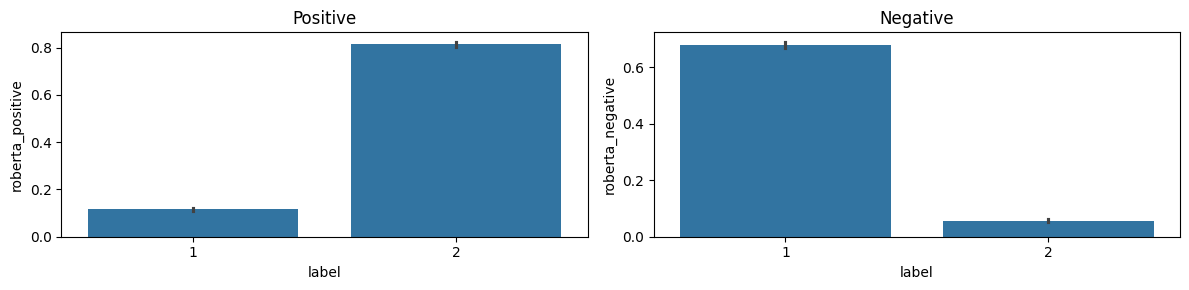

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
sns.barplot(data=sentimentDf, x='label', y='roberta_positive', ax=axs[0])
sns.barplot(data=sentimentDf, x='label', y='roberta_negative', ax=axs[1])
axs[0].set_title('Positive')
axs[1].set_title('Negative')
plt.tight_layout()
plt.show()

## 3.2 RoBERTa model apply on test set

In [7]:
#from tqdm import tqdm
#import pandas as pd
#from scipy.special import softmax

robertaTestResults = {}  # Initialize to store the sentiment analysis results for the test set

for i, row in tqdm(test.iterrows(), total=len(test)):
    text = row["text"]

    # Tokenize the text
    tokens = myTokenizer(text, return_tensors="pt", max_length=512, truncation=True)

    # Apply the tokens to the RoBERTa model
    out = myModel(**tokens)

    # Get the scores and convert to probabilities
    scores = out.logits[0].detach().numpy()  # Updated to use logits for clarity
    softScores = softmax(scores)

    # Map the results
    robertaScores = {
        "roberta_negative": softScores[0],
        "roberta_neutral": softScores[1],
        "roberta_positive": softScores[2],
        "predicted_label": 1 if softScores[0] > softScores[2] else 2
    }

    # Add to the results
    robertaTestResults[i] = robertaScores

# Convert the results to a DataFrame
robertaTestDf = pd.DataFrame(robertaTestResults).T

# If your test DataFrame has an index or ID column that you'd like to maintain, adjust accordingly
robertaTestDf = robertaTestDf.reset_index().rename(columns={"index": "Id"})

# Merge with the original test DataFrame to align each text with its sentiment analysis results
sentimentTestDf = robertaTestDf.merge(test, how="left", on="Id")

print(sentimentTestDf.head())


100%|██████████| 1000/1000 [06:13<00:00,  2.68it/s]

   Id  roberta_negative  roberta_neutral  roberta_positive  predicted_label  label                                               text
0   0          0.005815         0.024149          0.970036              2.0      2  Great CD: My lovely Pat has one of the GREAT v...
1   1          0.040374         0.114920          0.844705              2.0      2  One of the best game music soundtracks - for a...
2   2          0.320658         0.420270          0.259072              1.0      1  Batteries died within a year ...: I bought thi...
3   3          0.006435         0.099892          0.893673              2.0      2  works fine, but Maha Energy is better: Check o...
4   4          0.076798         0.252621          0.670581              2.0      2  Great for the non-audiophile: Reviewed quite a...


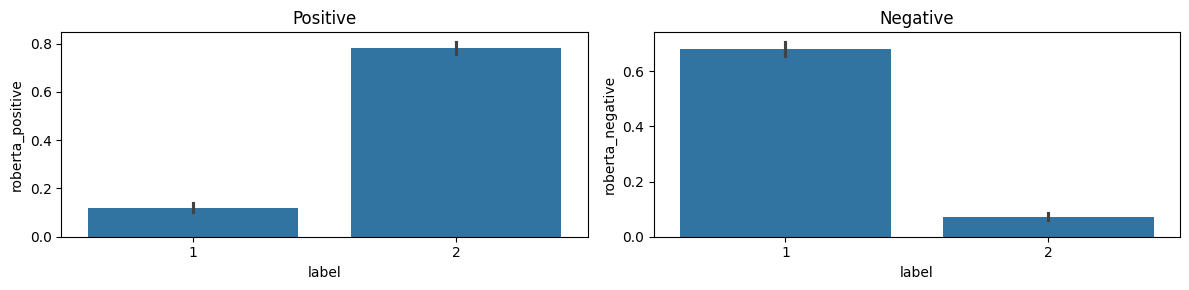

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
sns.barplot(data=sentimentTestDf, x='label', y='roberta_positive', ax=axs[0])
sns.barplot(data=sentimentTestDf, x='label', y='roberta_negative', ax=axs[1])
axs[0].set_title('Positive')
axs[1].set_title('Negative')
plt.tight_layout()
plt.show()

In [15]:
correct = 0

for i, row in sentimentDf.iterrows():

    if row["label"] == int(row["predicted_label"]):
        correct += 1


accuracy = correct / len(sentimentDf)
print(f"Accuracy is {accuracy}")


Accuracy is 0.8952222222222223


In [9]:
actual_labels = test["label"].astype(int)  # Make sure this column exists in your test DataFrame
predicted_labels = sentimentTestDf["predicted_label"].astype(int)  # Assuming sentimentTestDf contains predictions for the test set

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

precision = precision_score(actual_labels, predicted_labels)
recall = recall_score(actual_labels, predicted_labels)
f1 = f1_score(actual_labels, predicted_labels)

# To calculate specificity, first get the confusion matrix
tn, fp, fn, tp = confusion_matrix(actual_labels, predicted_labels).ravel()

# Specificity (also called True Negative Rate)
specificity = tn / (tn + fp)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")

Precision: 0.889344262295082
Recall: 0.868
F1 Score: 0.8785425101214576
Specificity: 0.868


The performance metrics for RoBERTa model:
* A precision of 0.889 means that approximately 88.9% of the reviews predicted as positive or negative by the model are correctly classified.
* A recall of 0.868 signifies that the model successfully identifies about 86.8% of the actual positive reviews.
* An F1 score of approximately 0.8785 indicates a good balance between precision and recall which means demonstrating a well performance in identifying both positive and negative reviews.
* With specificity also at 0.868, the model shows an equal performance in identifying negative reviews as it does with positive reviews.
* An accuracy of about 89.5% indicates that the model correctly predicts the sentiment of nearly 9 out of 10 reviews. This high level of accuracy showcases the effectiveness of the RoBERTa model in handling sentiment analysis tasks.

The confusion matrix for the test set is : 


<Axes: >

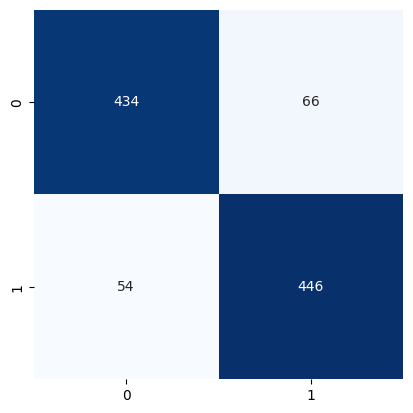

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, predicted_labels)

print('The confusion matrix for the test set is : ')
sns.heatmap(cm, square = True, annot = True, cmap = 'Blues', fmt = 'd', cbar = False)

In [15]:
predicted_yes = cm[0,1]+cm[1,1]
predicted_no = cm[0,0]+cm[0,1]
print(predicted_yes)
print(predicted_no)

512
500


In [16]:
positive_reviews = cm[1,0]+cm[1,1]
negative_reviews = cm[0,0]+cm[0,1]
print(positive_reviews)
print(negative_reviews)

500
500


## Conclusion

The model demonstrates strong performance across all key metrics. The high precision indicates few false positives, while the high recall shows that it misses few actual positives. The equal values of recall and specificity suggest a balanced ability to identify both positive and negative reviews accurately. The F1 score confirms a good balance between precision and recall, meaning the model makes its decisions confidently without being too cautious or too aggressive. High accuracy proves the model's strong ability in sorting reviews into positive and negative groups.

The balanced performance across precision, recall, and specificity, combined with high overall accuracy, suggests that the RoBERTa model is well-tuned for this dataset, offering a solid option for sentiment analysis with a focus on both positive and negative review identification.